# Copy of the Original dance_model.ipynb

This version trains on the joints without their respective confidence score given by OpenPose.

In [25]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, feature, data, color, exposure, transform
from sklearn.model_selection import train_test_split


In [26]:
image_labels = pd.read_csv('dance_label.txt', sep=' ', header=None, names=['image', 'label'])
image_labels = image_labels.to_numpy()
np.unique(image_labels[:, 1], return_counts=True)

(array([0, 1, 2, 3], dtype=object), array([2073,  104,  114,  106]))

In [35]:
prefix_to_youtube_video = {
    "CorbinHolooway1": "https://www.youtube.com/watch?v=PAepvwuWoRs",
    "CorbinHolooway2": " https://www.youtube.com/watch?v=PAepvwuWoRs",
    "AvaGuirl": "https://www.youtube.com/watch?v=YUmkT_lWWVM",
    "BridgetWilde": "https://www.youtube.com/watch?v=LKCZCtcO1Do",
    "BalletClass": "https://www.youtube.com/watch?v=M0GMx0vk8Ec",
    "JuaKim": "https://www.youtube.com/watch?v=Hg2IKQnvlsY",
    "TomokaSato": "https://www.youtube.com/watch?v=ICcwOsQOaow",
    "JohnCrim": "https://www.youtube.com/watch?v=QWKaJIQ2ATU",
    "ShogoHayami": "https://www.youtube.com/watch?v=Ag31VgFNx6o",
    "AlexandraLamm": "https://www.youtube.com/watch?v=8_EAO0-MRTs",
    "PreciousAdams": "https://www.youtube.com/watch?v=YT95D6leFNI",
    "SemyonChudin": "https://www.youtube.com/watch?v=xZdhG63_dfM",
    "EnzoSan": "https://www.youtube.com/watch?v=abWgBvJDx_A",
    "RyanLenkey": "https://www.youtube.com/watch?v=2QDta2DWR4g",
    "MarianelaNunez": "https://www.youtube.com/watch?v=0SWtbwvhsas",
    "EricPoor": "https://www.youtube.com/watch?v=lRsLP9sadG8",
    "JoakimVisnes": "https://www.youtube.com/watch?v=boNHS6qClqY",
    "Arabesque": "https://www.youtube.com/watch?v=E9EVPDiW4uM"
}

In [27]:
import json

def get_joints(file):
    try:
        f = open(file, "r")
    except:
        return

    with f as file:
        loaded_json = json.load(f)
    joints = np.array(loaded_json['people'][0]['pose_keypoints_2d']).reshape(25, 3)
    return joints[:, :2].reshape(50)


In [37]:
X = []
json_data = {}
new_image_labels = []
for i, (image, label) in enumerate(image_labels):
    if label == 0 and np.random.random() > 0.3:
        continue
    joints = get_joints(f"openpose_json/{image[:-4]}_keypoints.json")
    if joints is None:
        continue
    X.append({'image': image, 'label': label, 'joints': joints})
    # json_data[image] = {
    #                     'image': image,
    #                     'label': label, 
    #                     'joints': list(joints), 
    #                     'youtube_video': prefix_to_youtube_video[image.split("_")[0]]
    #                     }
    new_image_labels.append([image, label])

# json_object = json.dumps(json_data, indent=4)
 
# Writing to sample.json
# with open("dance_data.json", "w") as outfile:
#     outfile.write(json_object)

X = np.array(X)
new_image_labels = np.array(new_image_labels)

In [23]:
# # Shuffle the data
print(len(X))
indices = np.arange(len(X))
np.random.RandomState(seed=42).shuffle(indices)
X_shuffled = X[indices]
stratify_labels = new_image_labels[indices, 1]

# Data split ratios
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Split dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(X_shuffled, stratify_labels,
                                                                    test_size=1-train_ratio, stratify=stratify_labels,
                                                                    random_state=42)
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data,
                                                                              temp_labels,
                                                                              test_size=test_ratio/(test_ratio + validation_ratio),
                                                                              stratify=temp_labels,
                                                                              random_state=42)

968


In [24]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(validation_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array(['0', '1', '2', '3'], dtype='<U23'), array([515,  83,  91,  85]))
(array(['0', '1', '2', '3'], dtype='<U23'), array([64, 11, 11, 11]))
(array(['0', '1', '2', '3'], dtype='<U23'), array([65, 10, 12, 10]))


In [97]:
def center_at_origin(joints):
    joints = np.array(joints).reshape(25, 2)
    joints[:, 0] -= np.min(joints[:, 0])
    joints[:, 1] -= np.min(joints[:, 1])
    return joints.reshape(50)

In [98]:
def get_XY(data):
    images = []
    X = []
    y = []
    for data_pt in data:
        images.append(data_pt['image'])
        # center_at_origin(data_pt['joints'])
        X.append(center_at_origin(data_pt['joints']))
        y.append(data_pt['label'])
    return images, np.array(X), np.array(y)

train_images, X_train, y_train = get_XY(train_data)
validation_images, X_validation, y_validation = get_XY(validation_data)
test_images, X_test, y_test = get_XY(test_data)

In [154]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# img = []
# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(6):
#     frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
# ani.save('movie.mp4')
# plt.show()


# # importing matplot lib
# import matplotlib.pyplot as plt
# import numpy as np
 
# # importing movie py libraries
# from moviepy.editor import VideoClip
# from moviepy.video.io.bindings import mplfig_to_npimage
 
# # numpy array
# x = np.linspace(-2, 2, 200)
 
# # duration of the video
# duration = 2
 
# # matplot subplot
# fig, ax = plt.subplots()
 
# # method to get frames
# def make_frame(t):
     
#     # clear
#     ax.clear()
     
#     # plotting line
#     ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * np.pi / duration * t), lw = 3)
#     ax.set_ylim(-1.5, 2.5)
     
#     # returning numpy image
#     return mplfig_to_npimage(fig)
 
# # creating animation
# animation = VideoClip(make_frame, duration = duration)
 
# # displaying animation with auto play and looping
# animation.ipython_display(fps = 20, loop = True, autoplay = True)

# import os
# import moviepy.video.io.ImageSequenceClip
# image_folder='folder_with_images'
# fps=1

# image_files = [os.path.join(image_folder,img)
#                for img in os.listdir(image_folder)
#                if img.endswith(".png")]
# clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
# clip.write_videofile('my_video.mp4')

In [102]:
def create_classification_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))  # Output layer with 4 units for 4 labels
    ])
    return model


# Model (SAVE, DON'T TOUCH)

In [ ]:
# Define the input shape
input_shape = (50,)

# Create the model
model = create_classification_model(input_shape)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print the model summary
model.summary()

In [19]:
model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/500
24/24 [==============================] - 0s 5ms/step - loss: 163.8548 - accuracy: 0.5081 - val_loss: 108.7790 - val_accuracy: 0.6522
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 153.0392 - accuracy: 0.5298 - val_loss: 103.1068 - val_accuracy: 0.6522
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 158.3000 - accuracy: 0.5068 - val_loss: 95.8145 - val_accuracy: 0.6522
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 140.8016 - accuracy: 0.5054 - val_loss: 88.9327 - val_accuracy: 0.6522
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 140.4275 - accuracy: 0.4675 - val_loss: 84.2036 - val_accuracy: 0.6522
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 124.8700 - accuracy: 0.4783 - val_loss: 79.6572 - val_accuracy: 0.6522
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 125.2935 - accuracy: 0.4648 - val_loss: 76.3788 - val_accurac

# More model, ok to touch

In [103]:
# Define the input shape
input_shape = (50,)

# Create the model
all_none_model = create_classification_model(input_shape)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
all_none_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = all_none_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/500
60/60 [==============================] - 0s 3ms/step - loss: 92.9944 - accuracy: 0.6886 - val_loss: 62.0224 - val_accuracy: 0.8292
Epoch 2/500
60/60 [==============================] - 0s 3ms/step - loss: 83.2333 - accuracy: 0.7428 - val_loss: 60.8781 - val_accuracy: 0.8625
Epoch 3/500
60/60 [==============================] - 0s 2ms/step - loss: 80.5799 - accuracy: 0.7548 - val_loss: 59.4728 - val_accuracy: 0.8625
Epoch 4/500
60/60 [==============================] - 0s 2ms/step - loss: 76.9612 - accuracy: 0.7752 - val_loss: 57.0880 - val_accuracy: 0.8625
Epoch 5/500
60/60 [==============================] - 0s 2ms/step - loss: 71.4710 - accuracy: 0.7804 - val_loss: 54.6270 - val_accuracy: 0.8625
Epoch 6/500
60/60 [==============================] - 0s 2ms/step - loss: 71.0887 - accuracy: 0.7626 - val_loss: 52.4555 - val_accuracy: 0.8625
Epoch 7/500
60/60 [==============================] - 0s 1ms/step - loss: 69.1572 - accuracy: 0.7632 - val_loss: 51.1886 - val_accuracy: 0.8583

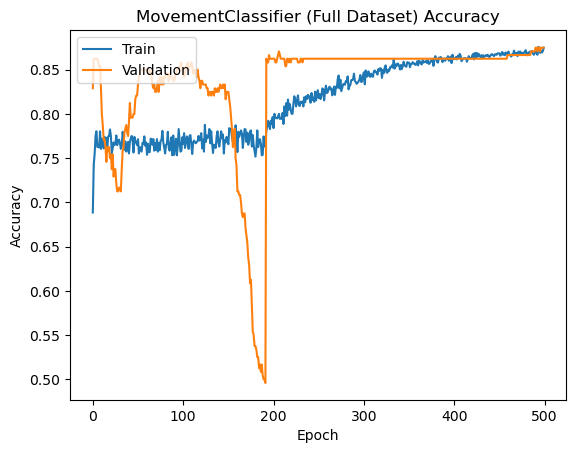

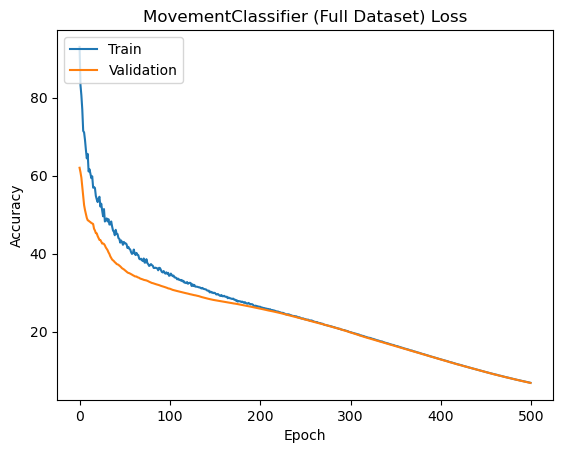

In [114]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MovementClassifier (Full Dataset) Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MovementClassifier (Full Dataset) Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Graphs

In [40]:
# Define the input shape
input_shape = (50,)

# Create the model
new_model = create_classification_model(input_shape)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
new_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = new_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/500
24/24 [==============================] - 0s 6ms/step - loss: 292.9299 - accuracy: 0.1423 - val_loss: 226.1495 - val_accuracy: 0.0761
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 258.4724 - accuracy: 0.1626 - val_loss: 187.8103 - val_accuracy: 0.0870
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 226.8790 - accuracy: 0.1680 - val_loss: 154.9470 - val_accuracy: 0.0978
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 196.0261 - accuracy: 0.2236 - val_loss: 133.2102 - val_accuracy: 0.1848
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 186.0906 - accuracy: 0.2371 - val_loss: 117.0796 - val_accuracy: 0.1848
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 169.2430 - accuracy: 0.2737 - val_loss: 107.2921 - val_accuracy: 0.2609
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 169.1432 - accuracy: 0.2710 - val_loss: 101.0208 - val_ac

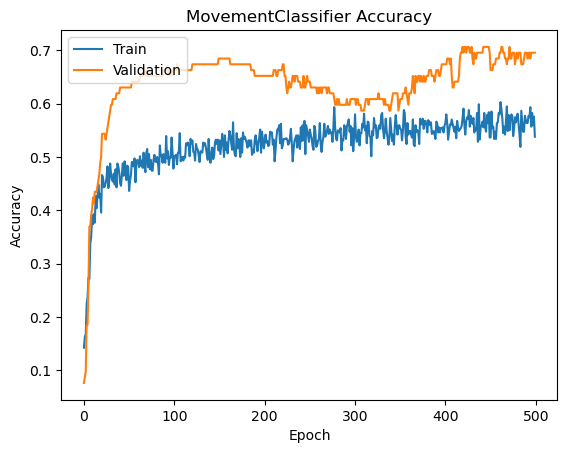

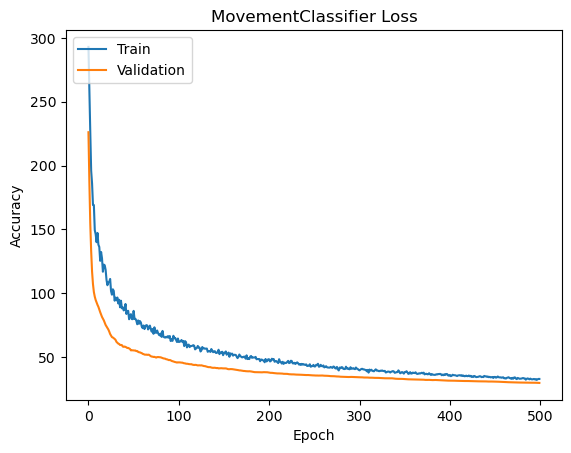

In [91]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MovementClassifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MovementClassifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Visualize

In [107]:
classifications = ['None', 'Grand Jete', 'Arabesque', 'Passe']
def visualize_results(type: str, num_visualize=10, random_visualize=False):
    if type == "test":
        X = X_test
        images = test_images
        y = y_test
    elif type == "validation":
        X = X_validation
        images = validation_images
        y = y_validation
    elif type == "training":
        X = X_train
        images = train_images
        y = y_train

    if random_visualize:
        indices = np.random.permutation(len(X))[:num_visualize]
    else:
        indices = np.arange(num_visualize)

    y_est = all_none_model.predict(X)
    all_none_model.evaluate(X, y)

    # print(y_true.shape)
    # confusion_matrix = np.zeros((4, 4))
    # num_tot = np.zeros(4)
    for i in indices:
        # image = images[i]
        classification = y_est[i]
        
        # confusion_matrix[y[i], np.argmax(classification)] += 1
        # label = f"Guess: {classifications[np.argmax(classification)]}, True: {classifications[y[i]]}"
        # img = io.imread(f"openpose_output/{image[:-4]}_rendered.jpg")
        # plt.imshow(img, cmap='gray')
        # plt.axis('off')  # Turn off axis labels
        # plt.text(0.5, -0.1, label, ha='center', va='center', transform=plt.gca().transAxes)
        # plt.show()
    return y, np.argmax(y_est, axis=1)

In [89]:
# model.save_weights('./dance_checkpoints/MovementClassifier')

8/8 [==============================] - 0s 769us/step - loss: 6.8697 - accuracy: 0.8750


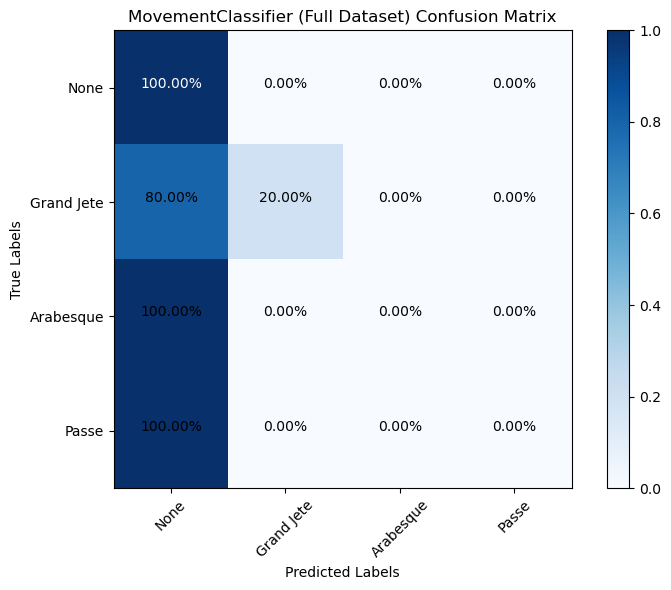

In [113]:
from sklearn.metrics import confusion_matrix


y_true, y_pred = visualize_results("test", random_visualize=True, num_visualize=len(X_test))
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_pct = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_pct, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MovementClassifier (Full Dataset) Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classifications))
plt.xticks(tick_marks, classifications, rotation=45)
plt.yticks(tick_marks, classifications)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add numerical annotations
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat_pct[i, j], '.2%'), horizontalalignment='center', color='white' if conf_mat[i, j] > conf_mat.max() / 2 else 'black')

plt.tight_layout()
plt.show()

annabelle_arabesque
1/1 [==============================] - 0s 14ms/step
[[1.0000000e+00 9.4696397e-11 5.4793180e-16 3.2284378e-20]]


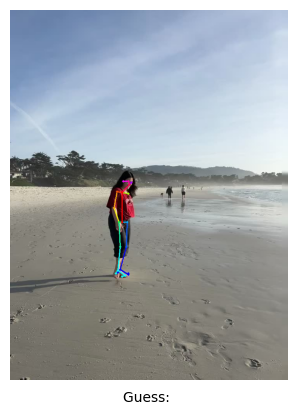

1/1 [==============================] - 0s 15ms/step
[[1.0000000e+00 8.2418156e-11 6.3690805e-16 3.1932849e-20]]


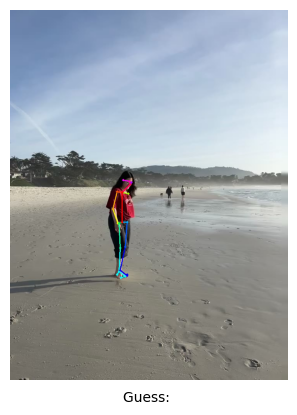

1/1 [==============================] - 0s 20ms/step
[[1.0000000e+00 9.4264985e-11 4.3804912e-16 2.9418255e-20]]


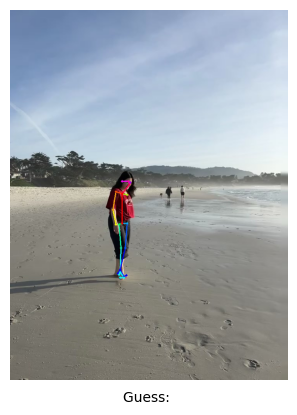

1/1 [==============================] - 0s 14ms/step
[[1.0000000e+00 3.8290884e-11 3.8215488e-16 2.7761845e-20]]


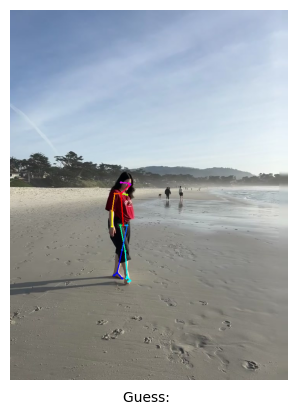

1/1 [==============================] - 0s 25ms/step
[[1.0000000e+00 1.1849447e-09 5.0740862e-13 3.9297650e-08]]


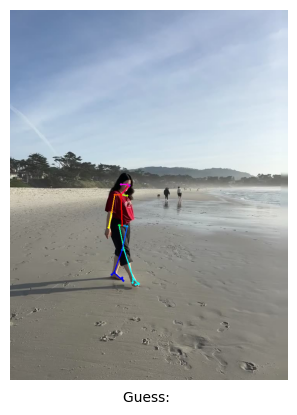

1/1 [==============================] - 0s 14ms/step
[[1.0000000e+00 2.0235638e-12 9.9287296e-16 1.6540690e-12]]


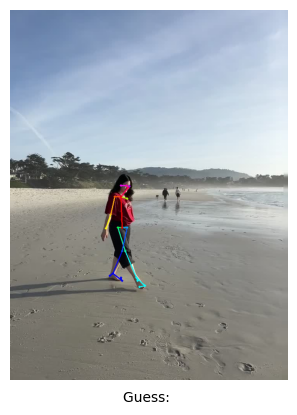

1/1 [==============================] - 0s 15ms/step
[[1.0000000e+00 1.4891421e-09 2.8530850e-15 6.0272343e-10]]


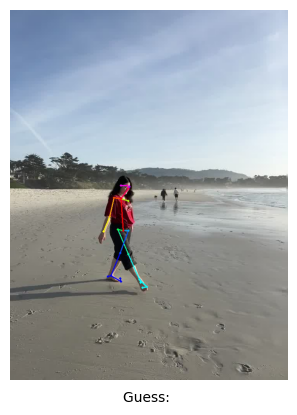

1/1 [==============================] - 0s 14ms/step
[[9.9999952e-01 2.2099953e-09 5.7823207e-13 5.3642162e-07]]


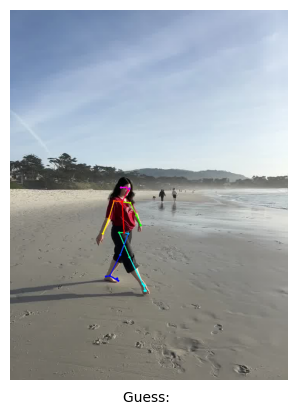

1/1 [==============================] - 0s 14ms/step
[[9.9999869e-01 5.8994791e-09 4.1077439e-13 1.3420695e-06]]


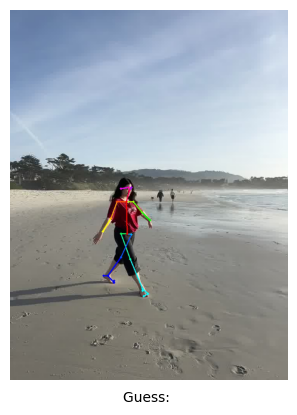

1/1 [==============================] - 0s 13ms/step
[[9.9999964e-01 9.6148094e-09 9.9136160e-14 4.0724132e-07]]


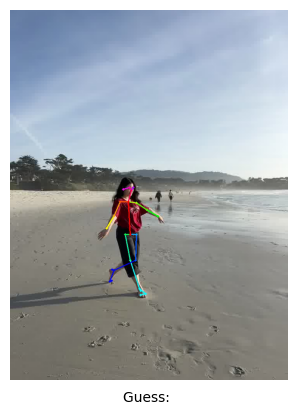

1/1 [==============================] - 0s 14ms/step
[[1.0000000e+00 1.2702233e-08 5.4211925e-14 4.6105921e-08]]


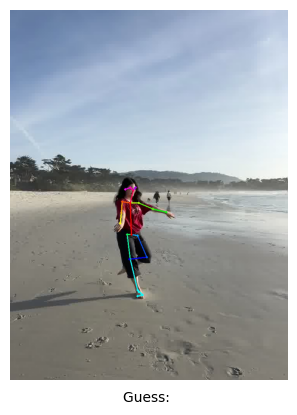

1/1 [==============================] - 0s 31ms/step
[[9.9999893e-01 1.2912363e-07 3.0223415e-12 9.0153867e-07]]


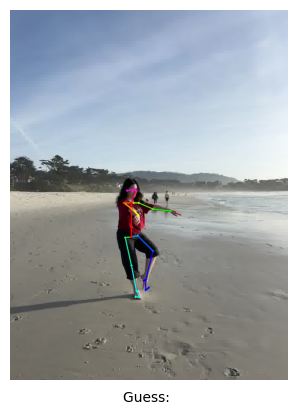

1/1 [==============================] - 0s 15ms/step
[[9.9999750e-01 2.5609943e-06 4.4732894e-12 9.7934105e-10]]


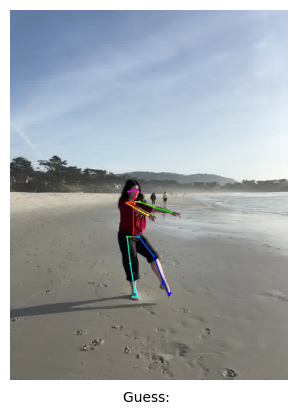

1/1 [==============================] - 0s 14ms/step
[[9.9999964e-01 1.7948916e-07 8.6834484e-11 7.8983177e-08]]


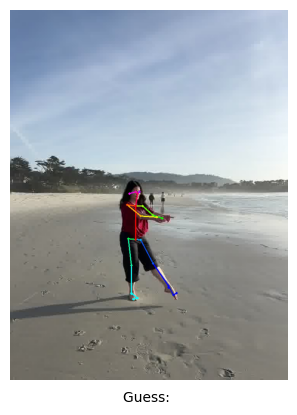

1/1 [==============================] - 0s 18ms/step
[[9.9999988e-01 8.0123016e-08 1.2312820e-10 2.7820105e-08]]


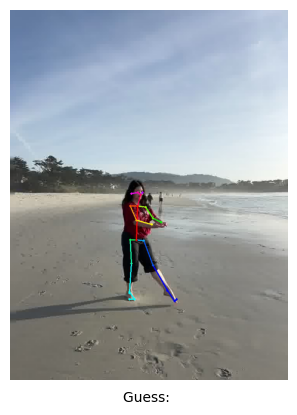

1/1 [==============================] - 0s 15ms/step
[[9.9999964e-01 2.6056435e-07 7.1867345e-10 8.5560309e-08]]


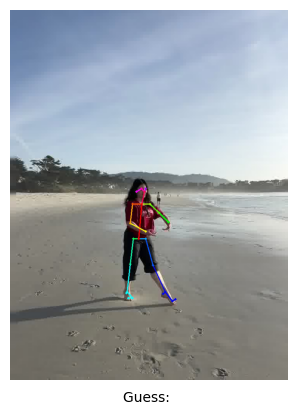

1/1 [==============================] - 0s 14ms/step
[[9.9999928e-01 4.5856004e-07 1.9114716e-09 2.0448607e-07]]


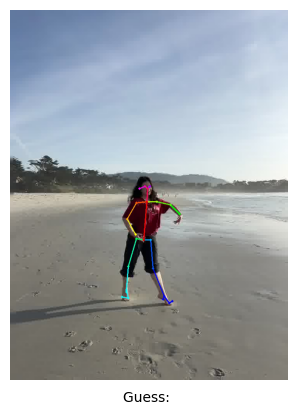

1/1 [==============================] - 0s 15ms/step
[[9.9999893e-01 1.0945749e-06 1.4490212e-08 4.3902908e-08]]


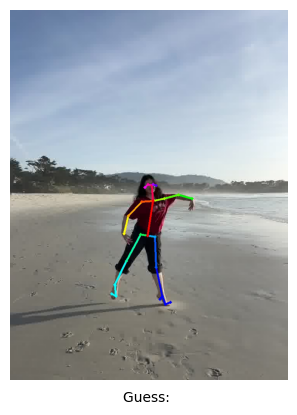

1/1 [==============================] - 0s 14ms/step
[[9.9998176e-01 1.8007369e-05 1.7703778e-07 1.9395411e-08]]


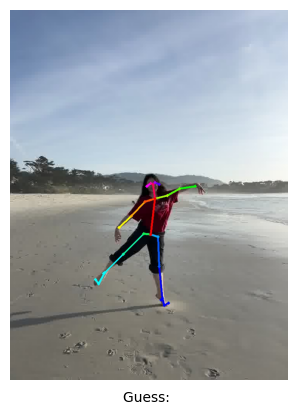

1/1 [==============================] - 0s 14ms/step
[[9.9959904e-01 3.9919719e-04 1.7724490e-06 4.3735692e-08]]


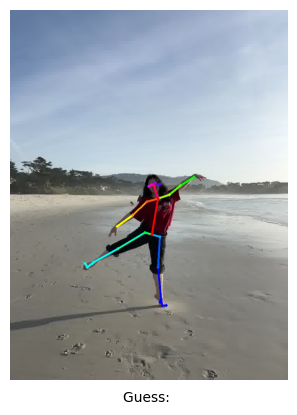

1/1 [==============================] - 0s 13ms/step
[[9.9839538e-01 1.6023333e-03 2.2442159e-06 3.8079079e-08]]


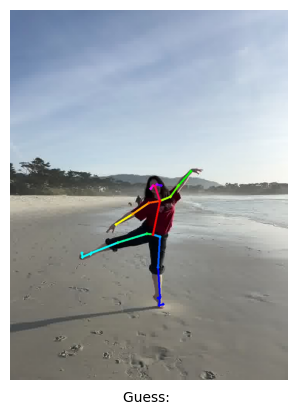

1/1 [==============================] - 0s 14ms/step
[[9.9716622e-01 2.8318565e-03 1.7890610e-06 7.0104981e-08]]


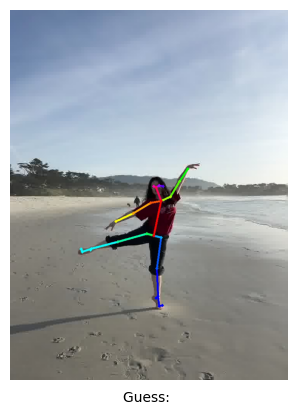

1/1 [==============================] - 0s 14ms/step
[[9.9854302e-01 1.4556486e-03 1.2274126e-06 7.0453019e-08]]


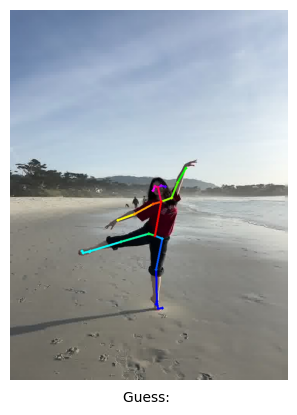

1/1 [==============================] - 0s 15ms/step
[[9.9893886e-01 1.0599907e-03 1.2131701e-06 3.7080472e-08]]


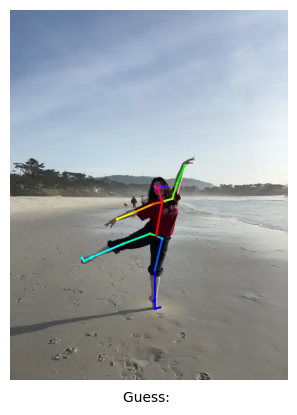

1/1 [==============================] - 0s 14ms/step
[[9.9982423e-01 1.7540516e-04 3.0547486e-07 2.1182187e-08]]


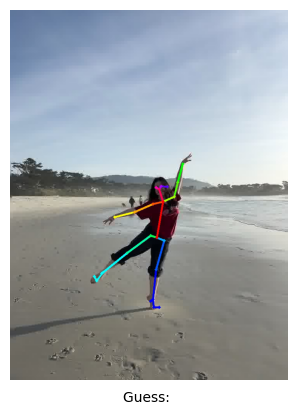

1/1 [==============================] - 0s 25ms/step
[[9.9998379e-01 1.6042442e-05 1.5092118e-08 1.2606792e-07]]


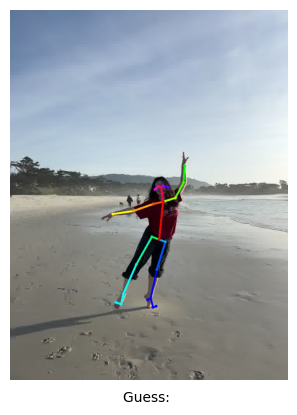

In [93]:
infer_images = []
X_infer = []
base = "annabelle_arabesque"
num_frames = 100
label_confidences = []
print(base)
for i in range(1, num_frames + 1):
    base_image = f"{base}_{i}"
    joints = get_joints(f"dance_predictions/{base}/json/{base_image}_keypoints.json")
    # print(f"dance_predictions/{base}/output/{base_image}_keypoints.json")
    if joints is None:
        continue
    # X.append(joints)
    # print(joints)
    # infer_images.append(f"dance_predictions/{base}/output/{base_image}_rendered.jpg")
    label_confidences = model.predict(np.expand_dims(joints, axis=0))
    classification = classifications[np.argmax(label_confidences)]
    print(label_confidences)
    if classification == "None":
        label = "Guess: "
    else:
        label = f"Guess: {classification}"
    img = io.imread(f"dance_predictions/{base}/output/{base_image}_rendered.jpg")
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.text(0.5, -0.05, label, ha='center', va='center', transform=plt.gca().transAxes)
    # plt.savefig(f"dance_predictions/{base}/processed/{base_image}.jpg")
    plt.show()